# Ireson Benchmark — Implicit FD scheme with Picard linearisation (ψ-form)

This notebook solves the **1D Richards’ Equation** using an **implicit finite-difference (FD)** scheme with **Picard iterations** for the **Ireson et al. (2022)** benchmark. The upper boundary is a **10-year daily rainfall** series (infiltration flux), and the lower boundary is **free drainage**.

## Governing Equation ($\psi$-based form of Richards’ Equation):
$
C(\psi)\frac{\partial \psi}{\partial t} = \frac{\partial}{\partial z}\left[K(\psi)\left(\frac{\partial \psi}{\partial z} - 1\right)\right]
$
- $\psi$: pressure head [cm]
- $C(\psi)$: specific moisture capacity [1/cm]
- $K(\psi)$: hydraulic conductivity [cm/s]

**Soil model:** Mualem–van Genuchten (parameters set below).  
**Domain:** 1.5 m depth with uniform grid.  
**Time:** 10 years (daily steps driven by rainfall series).  
**BCs:**  
- Top: **prescribed flux** (rainfall/evaporation time series).  
- Bottom: **unit hydraulic gradient** (free drainage).  


# INPUT SECTION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Flexible loader that works in Jupyter (local) and Colab ---
# It tries, in order: (1) Colab upload widget; (2) local file picker (tkinter); (3) manual path input.
# Your parsing settings (skiprows=1, delimiter=',', usecols=1) are preserved.
import io

try:
    # 1) Google Colab upload (works only in Colab)
    from google.colab import files  # noqa: F401
    print("Running in Colab: use the file picker to upload your infiltration .dat/.csv file…")
    uploaded = files.upload()  # prompts a file chooser
    fname = next(iter(uploaded))  # first (and usually only) file name
    rain_evap = np.loadtxt(io.BytesIO(uploaded[fname]),
                           skiprows=1, delimiter=',', usecols=1)
except Exception:
    try:
        # 2) Local file dialog (Jupyter on your machine)
        import tkinter as tk
        from tkinter import filedialog
        tk.Tk().withdraw()
        fname = filedialog.askopenfilename(
            title="Select infiltration .dat/.csv file",
            filetypes=[("Data files", "*.dat *.csv *.txt"), ("All files", "*.*")]
        )
        if not fname:
            raise RuntimeError("No file selected.")
        rain_evap = np.loadtxt(fname, skiprows=1, delimiter=',', usecols=1)
    except Exception:
        # 3) Manual path entry (last resort)
        fname = input("Enter full path to infiltration .dat/.csv file: ").strip()
        rain_evap = np.loadtxt(fname, skiprows=1, delimiter=',', usecols=1)

num_values = rain_evap.size
num_values  # quick check

Running in Colab: use the file picker to upload your infiltration .dat/.csv file…


Saving infiltration.dat to infiltration.dat


3653

In [3]:
# INPUT DATA
def setpars():
    pars={}
    # van Genuchten–Mualem soil parameters:
    pars['thetaR']=0.131   # residual volumetric water content [-]
    pars['thetaS']=0.396   # saturated volumetric water content [-]
    pars['alpha']=0.423    # inverse air-entry pressure [1/cm]
    pars['n']=2.06         # pore-size distribution parameter [-]
    pars['m']=1-1/pars['n']# m = 1 - 1/n (van Genuchten relation)
    pars['Ks']=0.0496      # saturated hydraulic conductivity [cm/s]
    pars['Ss']=0.000001    # specific storage [1/cm] used when ψ >= 0 (saturated)
    return pars

pars=setpars()

# Convert rainfall/evaporation series (e.g., mm/day) to model flux units if needed.
# Here: rain_evap presumably in mm/day -> divide by 1000 to get m/day (then neg sign for downward infiltration).
qT=rain_evap/1000*-1   # top flux boundary (negative = infiltration downward)
t=np.arange(len(qT))   # day index array
dt=t[1]-t[0]           # time step in "days" based on series spacing (should be 1)
nt=len(t)              # number of time steps

# Spatial grid:
dz=0.05                # grid spacing [m]
zN=1.5                 # domain depth [m]
z=np.arange(dz/2,zN,dz)# cell-centred grid from dz/2 to zN-dz/2
n=len(z)               # number of interior nodes

# Initialize array for pressure head ψ(z,t) [cm]
psi=np.zeros((nt,n))

# ICs: uniform initial condition in pressure head [cm] (partially wet)
psi[0,:]=-3.59

# MODEL SET UP

In [4]:
# ---------------------------
# DEPENDENT VARIABLES AND NUMERICAL SCHEME
# ---------------------------

def Cfun(psi,pars):
    # Specific moisture capacity C(ψ) = dθ/dψ.
    # Uses van Genuchten relation and returns Ss when ψ >= 0 (saturated).
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**(pars['m']+1)
    x1=pars['alpha']*pars['n']*pars['m']*((pars['alpha']*np.abs(psi))**(pars['n']-1))/x2
    C = np.where(psi >= 0, pars['Ss'], (pars['thetaS']-pars['thetaR'])*x1)
    return C

def Kfun(psi,pars):
    # Unsaturated hydraulic conductivity K(ψ) using Mualem–van Genuchten.
    # Returns Ks when ψ >= 0 (saturated).
    x6=1+(pars['alpha']*np.abs(psi))**pars['n']
    x5=x6**(pars['m']*0.5)
    x4=((pars['alpha']*np.abs(psi))**(pars['n']-1))*(x6**(-pars['m']))
    x3=1-x4
    x2=x3**2.
    x1=x2/x5
    K = np.where(psi >= 0, pars['Ks'], pars['Ks']*x1)
    return K

def thetafun(psi,pars):
    # Water content θ(ψ) from van Genuchten curve.
    # Saturates to θs when ψ >= 0.
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**pars['m']
    x1=(pars['thetaS']-pars['thetaR'])/x2
    theta = np.where(psi >= 0, pars['thetaS'], pars['thetaR']+x1)
    return theta

def solverfun(R,C,Kmid,dt,dz,n):
    # Assemble and solve the tridiagonal linear system A * δ = R
    # where δ is the Picard increment for ψ.
    # Initialize arrays for the tridiagonal coefficients:
    a=np.zeros(n)  # sub-diagonal
    b=np.zeros(n)  # diagonal
    c=np.zeros(n)  # super-diagonal
    y=np.zeros(n)  # RHS

    # Interior coefficients (implicit in time; central in space):
    a=-Kmid[:-1]/dz
    b=(Kmid[:-1]+Kmid[1:])/dz+C*dz/dt
    c=-Kmid[1:]/dz

    # Lower boundary (free drainage): unit gradient -> modifies first diagonal
    b[0]=Kmid[1]/dz+C[0]*dz/dt

    # Upper boundary (flux BC): handled via R; here set last diagonal consistent
    b[-1]=Kmid[-2]/dz+C[-1]*dz/dt

    # Assemble tridiagonal matrix A
    A=np.diag(a[1:],-1)+np.diag(b,0)+np.diag(c[:-1],1)

    # Construct RHS
    y[:]=R[:]

    # Solve A δ = R
    dell = np.linalg.solve(A, y)
    return dell

def Rfun(psiiter,psiin,qT,KB,C,Kmid,dt,dz,n):
    # Picard residual vector R(ψ^{m}) for the ψ-form discretisation.
    # zero-padding for ghost nodes at top and bottom:
    zero=np.array([0])
    psigrid=np.hstack((zero,psiiter,zero))

    # Time term:
    x1=-C*(psiiter-psiin)/dt*dz
    # Gravity / K term (discrete divergence of K):
    x2=(Kmid[1:]-Kmid[:-1])
    # Diffusive head gradient terms:
    x3=Kmid[1:]*(psigrid[2:]-psigrid[1:-1])/dz
    x4=-Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2])/dz

    # Lower boundary: unit gradient -> replace terms accordingly
    x2[0]=Kmid[1]
    x4[0]=-KB

    # Upper boundary: prescribed flux qT -> enters as -qT in residual
    x2[-1]=-Kmid[-2]
    x3[-1]=-qT

    R=x1+x2+x3+x4
    return R

def iterfun(psiin,pars,qT,dt,dz,n):
    # One time step Picard iteration:
    #   psiin  = ψ^n
    #   psiiter= ψ^{n+1,m}
    #   psiout = ψ^{n+1,m+1}
    tolerance=1e-10
    maxcount=10000
    zero=np.array([0])

    # Allocate arrays
    psiiter=np.zeros(len(psiin))
    psiout=np.zeros(len(psiin))

    # Initial guess ψ^{n+1,1} = ψ^n
    psiiter[:]=psiin[:]

    count=0
    while count <= maxcount:
        # Compute C(ψ^m), K at faces, and Kmid (harmonic/arith. here average):
        C=Cfun(psiiter,pars)
        K=Kfun(np.hstack((zero, psiiter, zero)),pars)
        Kmid=(K[1:]+K[:-1])/2

        # Build residual at current iterate
        R=Rfun(psiiter,psiin,qT,K[1],C,Kmid,dt,dz,n)

        # Solve linearised system for increment δψ
        dell=solverfun(R,C,Kmid,dt,dz,n)

        # Update iterate
        psiout[:]=psiiter[:]+dell[:]
        psiiter[:]=psiout[:]

        # Convergence test on residual infinity norm
        if np.max(np.abs(R)) < tolerance:
            break

        count+=1

    return psiout

def massbal(psi,qT,pars,n,dt,dz):
    # Mass balance diagnostics over the whole simulation.

    # Storage (integral of θ over depth) at each time level:
    theta=thetafun(psi.reshape(-1),pars)
    theta=np.reshape(theta,psi.shape)
    S=np.sum(theta*dz,1)   # [m] if θ is [-] and dz [m]
    S0=S[0]
    SN=S[-1]

    # Inflow at top boundary: K(ψ) evaluated at surface; sign -> inward positive
    Kin=Kfun(psi[:,0],pars)
    QIN=-Kin
    QIN[0]=0.
    QINsum=np.sum(QIN)*dt

    # Outflow equals imposed top flux series qT (sign convention consistent above)
    QOUT=qT
    QOUT[0]=0.
    QOUTsum=np.sum(QOUT)*dt

    # Mass balance error metric:
    dS=SN-S0
    dQ=QINsum-QOUTsum
    err=dS/dQ

    return QIN,QOUT,S,err

def ModelRun(dt,dz,n,nt,psi,qT,pars):
    # March in time using Picard iteration at each step:
    for j in range(1,nt):
        psi[j,:]=iterfun(psi[j-1,:],pars,qT[j],dt,dz,n)

    # After time integration, compute mass balance arrays:
    QIN,QOUT,S,err=massbal(psi,qT,pars,n,dt,dz)
    return psi,QIN,QOUT,S,err

# SIMULATION RUN

In [5]:
psi,QIN,QOUT,S,err=ModelRun(dt,dz,n,nt,psi,qT,pars)
err, psi   # Inspect mass-balance error and final ψ array

(np.float64(0.014676388801151262),
 array([[-3.59      , -3.59      , -3.59      , ..., -3.59      ,
         -3.59      , -3.59      ],
        [-3.59018413, -3.59019736, -3.59022415, ..., -3.68356043,
         -3.71162835, -3.74887412],
        [-3.59098644, -3.59104414, -3.59115997, ..., -3.76082642,
         -3.79644798, -3.83881772],
        ...,
        [-3.44101164, -3.44183053, -3.44342537, ..., -3.47686513,
         -3.48568954, -3.51026516],
        [-3.45178065, -3.4524849 , -3.45385262, ..., -3.59004307,
         -3.61933858, -3.65815952],
        [-3.46066192, -3.46124628, -3.46237937, ..., -3.49347693,
         -3.4773285 , -3.45294561]]))

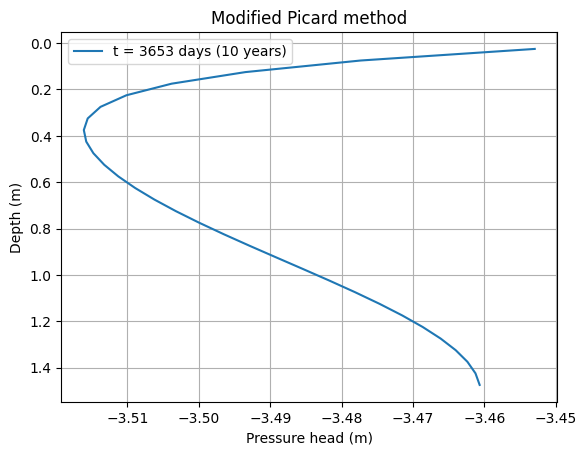

In [6]:
# Plotting psi at the last time step
z_depth = np.flip(z)
psi_plot = plt.plot(psi[3652], z_depth, label='t = 3653 days (10 years)') # Plot z vs psi for each dti
plt.xlabel('Pressure head (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

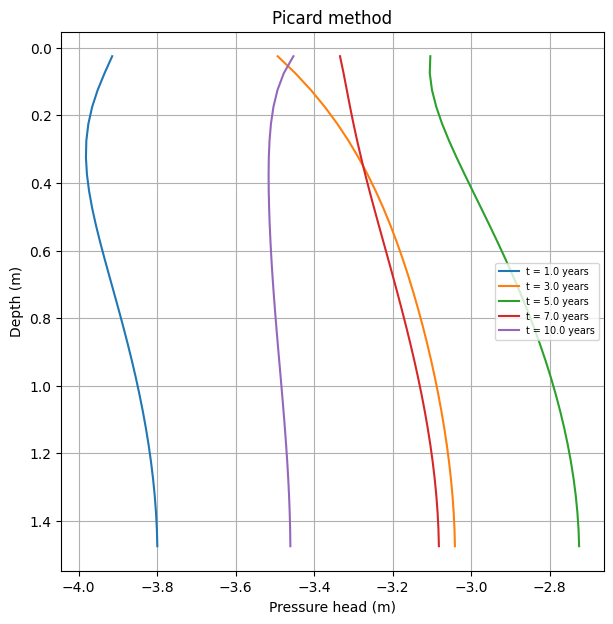

In [7]:
# Specify the time steps you want to plot
time_steps = [366, 1098, 1826, 2921, 3652]  # Adjusted for zero-indexing

plt.figure(figsize=(7, 7))
# Loop through the specified time steps
for t in time_steps:
    plt.plot(psi[t], z_depth, label=f't = {t//365.2} years')  # t+1 because of zero-indexing but your days start from 1

plt.xlabel('Pressure head (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.title('Picard method')
plt.legend(loc='right', fontsize='x-small')  # Adjust 'x-small' to 'x-small' if needed

plt.grid(True)
plt.show()

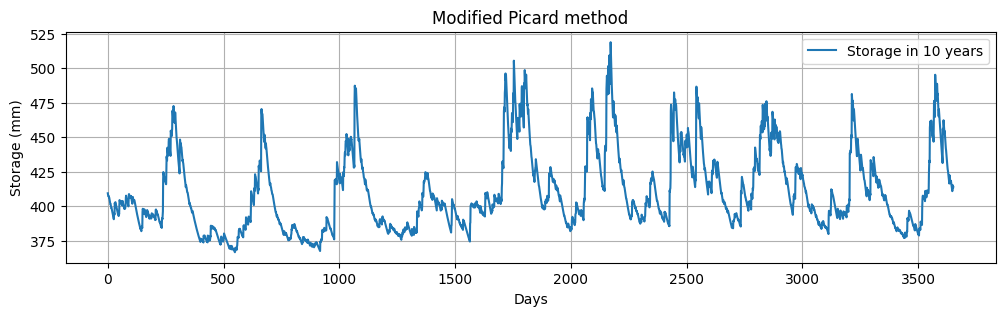

In [8]:
# Time axis for storage plot
days=np.arange(len(qT))
storage=S*1000   # Convert storage to mm for plotting

plt.figure(figsize=(12, 3))
storage_plot = plt.plot(days, storage, label='Storage in 10 years') # Plot z vs psi for each dti
plt.xlabel('Days')
plt.ylabel('Storage (mm)')
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

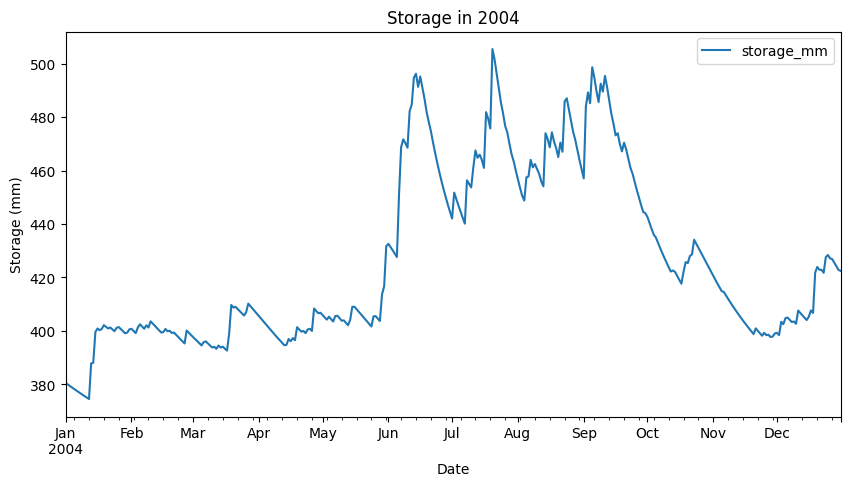

In [9]:
# Convert arrays to dataframes for time-series plotting and year filtering
days_df = pd.DataFrame({'days': days})
storage_df = pd.DataFrame({'storage_mm': storage})

# Combine days and storage
vol_df = pd.concat([days_df, storage_df], axis=1)

# Starting date for daily index (user can choose)
start_date = '1999-10-01'
vol_df['date'] = pd.date_range(start=start_date, periods=len(vol_df), freq='D')

# Filter one specific year (e.g., 2004) for comparison with HYDRUS
vol_df['date'] = pd.to_datetime(vol_df['date'])
vol_2004 = vol_df[vol_df['date'].dt.year == 2004]

# Plot our model's storage for 2004
vol_2004.plot(x='date', y='storage_mm', title='Storage in 2004', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Storage (mm)')
plt.show()


# COMPARISON WITH HYDRUS

In [10]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Let user pick HYDRUS output file (T_Level.out)
try:
    Tk().withdraw()
    file_path_hydrus = askopenfilename(title="Select T_Level.out file")
except:
    from google.colab import files
    uploaded = files.upload()
    file_path_hydrus = list(uploaded.keys())[0]

# Define column names based on file's structure
column_names = ['Time', 'rTop', 'rRoot', 'vTop', 'vRoot', 'vBot',
                'sum_rTop', 'sum_rRoot', 'sum_vTop', 'sum_vRoot', 'sum_vBot',
                'hTop', 'hRoot', 'hBot', 'RunOff', 'sum_RunOff', 'Volume',
                'sum_Infil', 'sum_Evap', 'TLevel', 'Cum_WTrans', 'SnowLayer']

# Read HYDRUS output with same format rules
data = pd.read_csv(file_path_hydrus, delim_whitespace=True, skiprows=8, names=column_names)
print(f"Loaded HYDRUS output from: {file_path_hydrus}")

Saving T_Level.out to T_Level.out
Loaded HYDRUS output from: T_Level.out


/tmp/ipython-input-2358253759.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path_hydrus, delim_whitespace=True, skiprows=8, names=column_names)


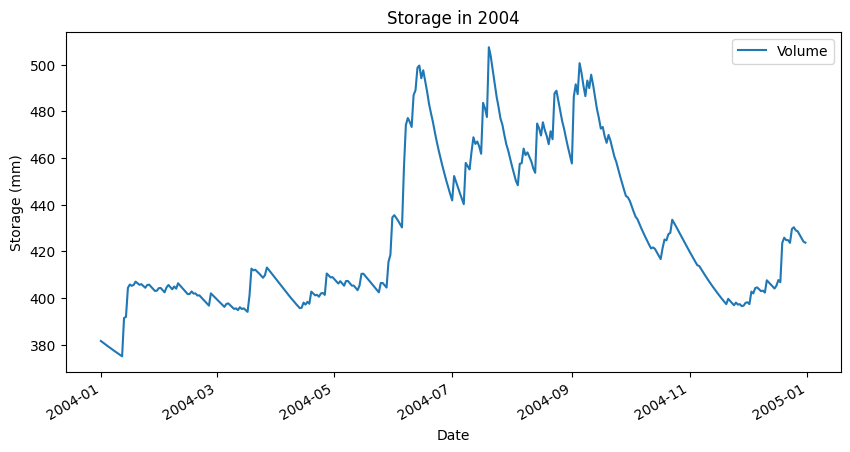

In [11]:
# Convert necessary columns to numeric types, handling errors by coercing invalid values to NaN
numeric_columns = ['Time', 'rTop', 'rRoot', 'vTop', 'vRoot', 'vBot', 'sum_rTop', 'sum_rRoot', 'sum_vTop', 'sum_vRoot', 'sum_vBot', 'hTop', 'hRoot', 'hBot', 'RunOff', 'sum_RunOff', 'Volume', 'sum_Infil', 'sum_Evap', 'TLevel', 'Cum_WTrans', 'SnowLayer']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Assuming 'vTop' and 'vBot' are velocities and 'Volume' is a volume measurement
# Convert these to the desired units (as per your original code)
Qin = -data['vTop'] * 1000  # Multiply by 1000 to convert to desired units
Qout = -data['vBot'] * 1000
S = data['Volume'] * 1000

# Calculate the time steps
start_date = '1999-9-30'
data['t'] = pd.to_datetime(start_date) + pd.to_timedelta(data['Time'], unit='D')

# Create a new DataFrame for the processed data
processed_data = pd.DataFrame({
    'dt': np.hstack([0, np.diff(data['Time'].values)]),
    'Qin': Qin,
    'Qout': Qout,
    'S': S,
    'dS': np.hstack([0, np.diff(S)]),
    'cQ': np.cumsum((Qin - Qout) * np.hstack([0, np.diff(data['Time'].values)]))
}, index=data['t'])

# Filtering the DataFrame for the year 2004
data['t'] = pd.to_datetime(data['t'])  # Ensure 'Date' is in datetime format
hydrus_2004 = data[data['t'].dt.year == 2004]
hydrus_2004.loc[:, 'Volume'] = hydrus_2004['Volume'] * 1000

# Now plot
hydrus_2004.plot(x='t', y='Volume', title='Storage in 2004', figsize=(10, 5))
plt.xlabel('Date')  # Optional: Customize the x-axis label
plt.ylabel('Storage (mm)')  # Optional: Customize the y-axis label
plt.show()

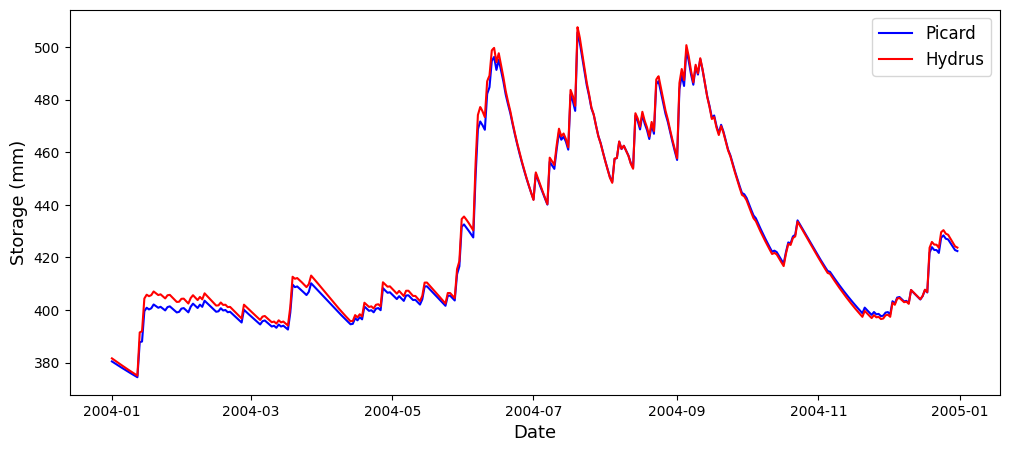

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 5)) # create axes for plotting the reduces variate and increase the size of the plot

ax1.plot(vol_2004.date, vol_2004.storage_mm, "b-", label="Picard") # plot our observed data
ax1.plot(hydrus_2004.t, hydrus_2004.Volume, "r-", label="Hydrus") # plot our fitted data for GEV distribution

ax1.set_xlabel("Date", fontsize=13) # label the axes
ax1.set_ylabel("Storage (mm)", fontsize=13)
ax1.legend(fontsize=12)

plt.show()